In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
from sklearn.preprocessing import RobustScaler

RATES_CSV_PATH = "../data/rates.csv"

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

df = pd.read_csv(RATES_CSV_PATH)
df.set_index('time', inplace=True)
df.drop(columns=['EMA_fast', 'EMA_medium', 'EMA_slow', 'MACD', 'RSI', 'Stoch', 'BB_upper', 'BB_middle', 'BB_lower', 'ATR', 'OBV', 'VWAP'], inplace=True)

start_datetime = df.index[0]
end_datetime = df.index[-1]
print(f"Data collected from {start_datetime} to {end_datetime}")

df_scaled = df.copy()

scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
df_scaled['unscaled_close'] = df['close']

print(df_scaled.shape)
print(df_scaled.tail())

# Split train/test (80/20)
split_idx = int(len(df) * 0.8)
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

Data collected from 2024-06-04 08:15:00 to 2025-02-19 07:00:00
(24950, 6)
                         open      high       low     close    volume  unscaled_close
time                                                                                 
2025-02-19 06:00:00  0.801343  0.800504  0.804637  0.804097  1.556329        95378.55
2025-02-19 06:15:00  0.804016  0.801273  0.806182  0.804739  1.422531        95400.67
2025-02-19 06:30:00  0.804666  0.801509  0.807717  0.804473  1.455713        95391.50
2025-02-19 06:45:00  0.804414  0.809388  0.808915  0.811847  1.420926        95645.48
2025-02-19 07:00:00  0.811786  0.812847  0.815579  0.815097  1.576666        95757.44


In [17]:
import joblib
from trade_environment import BitcoinTradingEnv
from stable_baselines3.common.env_util import make_vec_env
import gym
from stable_baselines3.common.callbacks import BaseCallback

class RenderCallback(BaseCallback):
    def __init__(self, render_freq=1000, verbose=0):
        super().__init__(verbose)
        self.render_freq = render_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            self.training_env.envs[0].render()
        return True

seed_value = np.random.randint(0, 100000)
# seed_value = 77074
print(f"Using seed: {seed_value}")

env = BitcoinTradingEnv(train_data)
env.action_space.seed(seed_value)
vec_env = make_vec_env(lambda: env, n_envs=1, seed=seed_value)

model = PPO("MlpPolicy", vec_env, verbose=0, n_epochs=20, learning_rate=0.00001, ent_coef=0.01, gamma=0.95, clip_range=0.2, n_steps=4096)

render_callback = RenderCallback(render_freq=1000)
model.learn(total_timesteps=10000, progress_bar=True)

model.save(f"./../results/{seed_value}")
joblib.dump(scaler, f"./../results/{seed_value}.pkl")

Output()

Using seed: 42767


['./../results/42767.pkl']

Current Balance: 5678960.11
Starting Balance: 10000.00
Total Return: 56689.60%
Total Trades: 3523
Total Win Rate: 1571 (44.59%)
Long Trades: 3522
Long Win Rate: 44.61%
Short Trades: 1
Short Win Rate: 0.00%
Average Win: 13729.62
Average Loss: 8145.63
Average RRR: 1.69
Expected Value: 1609.13
Kelly Criterion: 0.12
Half-Kelly Criterion: 0.06
Sharpe Ratio: 1.52
Training Seed: 42767
Reward: -2797.05


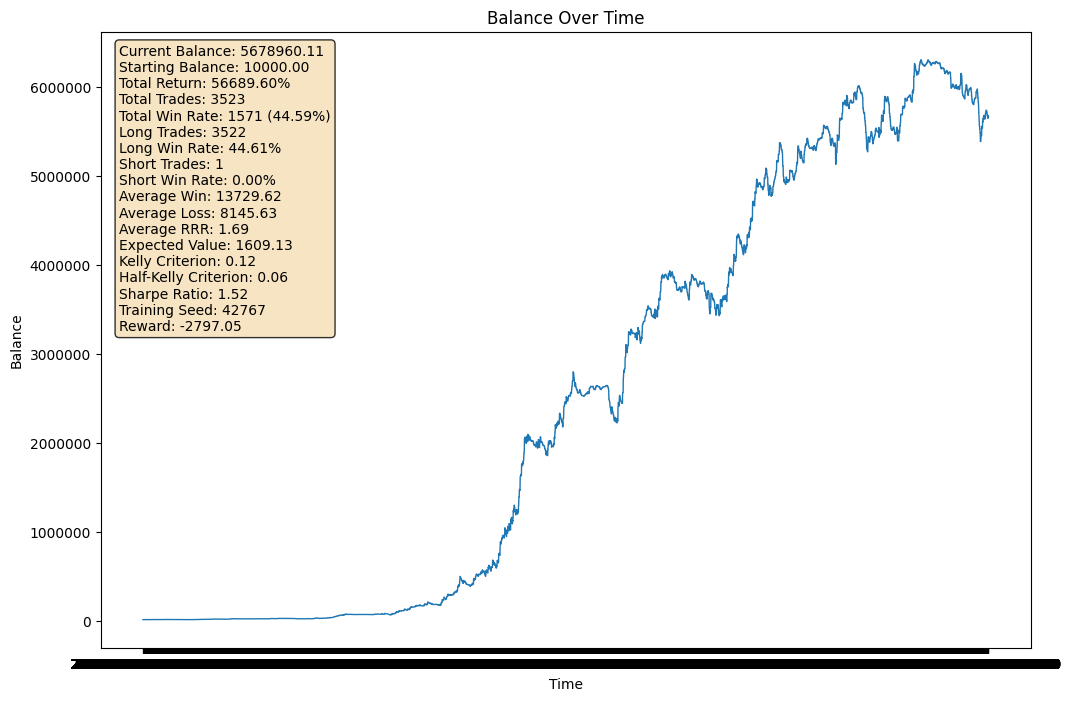

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate a test environment using test_data
test_env = BitcoinTradingEnv(test_data, initial_balance=10000.0)
test_env.action_space.seed(seed_value)

# Reset the test environment and get the initial observation
obs, info = test_env.reset()

reward_over_time = []
balance_over_time = []
actions_log = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    actions_log.append(action)
    obs, reward, terminated, truncated, info = test_env.step(action)
    
    done = terminated  # Ensure the loop exits properly
    balance_over_time.append(test_env.balance)
    reward_over_time.append(reward)

# Convert the list of completed trades to a DataFrame
trades_df = pd.DataFrame(test_env.trades)

def kelly_criterion(win_rate, win_loss_ratio):
    """
    Calculates the optimal fraction of capital to risk per trade using the Kelly Criterion.
    """
    if win_loss_ratio == 0:
        return 0.0  # Avoid division by zero
    return round(win_rate - ((1 - win_rate) / win_loss_ratio), 4)

def sharpe_ratio(returns, risk_free_rate=0.00, trading_periods=252):
    """
    Calculate the Sharpe Ratio for trading.
    """
    if len(returns) < 2: 
        return 0.0  # Avoid calculation on insufficient data
    excess_returns = np.array(returns) - (risk_free_rate / trading_periods)
    sharpe = np.mean(excess_returns) / np.std(excess_returns, ddof=1)
    return sharpe * np.sqrt(trading_periods)

total_trades = len(trades_df)
if total_trades == 0:
    print("No trades made.")
    exit()

num_tp = trades_df[trades_df["pnl"] > 0.0].shape[0]
num_sl = trades_df[trades_df["pnl"] < 0.0].shape[0]

perc_tp = (num_tp / total_trades * 100) if total_trades > 0 else 0.0
perc_sl = (num_sl / total_trades * 100) if total_trades > 0 else 0.0

avg_pnl_tp = trades_df[trades_df["pnl"] > 0.0]["pnl"].mean() if num_tp > 0 else 0.0
avg_pnl_sl = trades_df[trades_df["pnl"] < 0.0]["pnl"].mean() if num_sl > 0 else 0.0

total_return = ((test_env.balance - test_env.initial_balance) / test_env.initial_balance) * 100
expected_value = trades_df["pnl"].mean() if total_trades > 0 else 0.0

if num_tp > 0:
    avg_pnl_tp = trades_df[trades_df["pnl"] > 0.0]["pnl"].mean()
else:
    avg_pnl_tp = 0.0

if num_sl > 0:
    avg_pnl_sl = abs(trades_df[trades_df["pnl"] < 0.0]["pnl"].mean())
else:
    avg_pnl_sl = 0.0

rrr = avg_pnl_tp / avg_pnl_sl if avg_pnl_sl > 0 else 0.0

num_buy = trades_df[trades_df["position"] == 1].shape[0]
num_sell = trades_df[trades_df["position"] == -1].shape[0]

buy_win_rate = (trades_df[(trades_df["position"] == 1) & (trades_df["pnl"] > 0.0)].shape[0] / num_buy * 100) if num_buy > 0 else 0.0
sell_win_rate = (trades_df[(trades_df["position"] == -1) & (trades_df["pnl"] > 0.0)].shape[0] / num_sell * 100) if num_sell > 0 else 0.0
total_win_rate = (num_tp / total_trades * 100) if total_trades > 0 else 0.0

kelly_criteria = kelly_criterion(total_win_rate / 100.0, rrr) if not np.isnan(rrr) else 0.0

# Convert PnL to percentage returns for Sharpe ratio calculation
if total_trades > 0:
    daily_returns = trades_df["pnl"] / test_env.initial_balance
    sharpe = sharpe_ratio(daily_returns)
else:
    sharpe = 0.0

# Plot balance over time using real timestamps if available
plt.figure(figsize=(12, 8))
ax = plt.gca()

if hasattr(test_data, "index"):
    timestamps = test_data.index[:len(balance_over_time)]
    ax.plot(timestamps, balance_over_time, linewidth=1, linestyle='-')
else:
    ax.plot(balance_over_time, linewidth=1, linestyle='-')

ax.set_xlabel("Time")
ax.set_ylabel("Balance")
ax.set_title("Balance Over Time")
ax.ticklabel_format(style='plain', axis='y')

# Build multiline string for performance metrics
metrics_text = (
    f"Current Balance: {test_env.balance:.2f}\n"
    f"Starting Balance: {test_env.initial_balance:.2f}\n"
    f"Total Return: {total_return:.2f}%\n"
    f"Total Trades: {total_trades}\n"
    f"Total Win Rate: {num_tp} ({perc_tp:.2f}%)\n"
    f"Long Trades: {num_buy}\n"
    f"Long Win Rate: {buy_win_rate:.2f}%\n"
    f"Short Trades: {num_sell}\n"
    f"Short Win Rate: {sell_win_rate:.2f}%\n"
    f"Average Win: {avg_pnl_tp:.2f}\n"
    f"Average Loss: {avg_pnl_sl:.2f}\n"
    f"Average RRR: {rrr:.2f}\n"
    f"Expected Value: {expected_value:.2f}\n"
    f"Kelly Criterion: {kelly_criteria:.2f}\n"
    f"Half-Kelly Criterion: {kelly_criteria / 2:.2f}\n"
    f"Sharpe Ratio: {sharpe:.2f}\n"
    f"Training Seed: {seed_value}\n"
    f"Reward: {reward_over_time[-1]:.2f}"
)

print(metrics_text)

# Add annotation box in the upper left-hand corner
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig(f"./../results/{seed_value}.png")
plt.show()
